In [1]:
import arrow
import datetime
import gsw
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import xarray as xr

#from salishsea_tools import gsw_calls

%matplotlib inline

gsw.density.sigma0(SA, CT)

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

In [3]:
iY = 258; iX = 178; iZ = 28
depths = slice(0, iZ)
iY2 = 388; iX2 = 271
print (mesh.variables['gdepw_0'][0, iZ+1, iY2, iX2])

160.02956


In [4]:
e3t = mesh.variables['e3t_0'][0, :iZ, iY, iX]

In [5]:
def get_ts(start, endtime, numberofdays):
    timerange = arrow.Arrow.range('day', start, endtime)
    saltV = np.empty((numberofdays, iZ))
    tempV = np.empty_like(saltV)
    saltS = np.empty_like(saltV)
    tempS = np.empty_like(saltV)
    time = []
    for it, r in enumerate(timerange):
        dir1 = r.format('DDMMMYY').lower()
        ymd = r.format('YYYYMMDD')
        filename = f'SalishSea_1d_{ymd}_{ymd}_grid_T.nc'
        with xr.open_dataset(os.path.join('/results2/SalishSea/nowcast-green.201806/', dir1, filename)) as ds:
            saltV[it, :] = ds.vosaline[0, depths, iY, iX]
            saltS[it, :] = ds.vosaline[0, depths, iY2, iX2]
            tempV[it, :] = ds.votemper[0, depths, iY, iX]
            tempS[it, :] = ds.votemper[0, depths, iY2, iX2]
            time.append(r.datetime)
    return time, saltV, saltS, tempV, tempS

In [6]:
def find_mean_sigma(saltV, saltS, tempV, tempS):
    sigmaV = gsw.density.sigma0(saltV, tempV)

    tlen = sigmaV.shape[0]
    south = np.sum(sigmaV[0:tlen] * e3t, axis=1)

    sigmaS = gsw.density.sigma0(saltS, tempS)
    tlen = sigmaS.shape[0]
    north = np.sum(sigmaS[0:tlen] * e3t, axis=1)
    return south, north

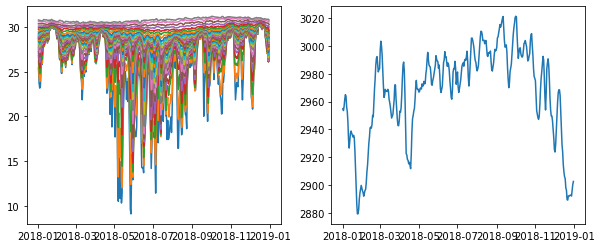

In [19]:
start = datetime.datetime(2018, 1, 1)
endtime = datetime.datetime(2018, 12, 31)
numberofdays = int((endtime - start)/(datetime.datetime(2015, 1, 2) - datetime.datetime(2015, 1, 1)) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
time, saltV, saltS, tempV, tempS = get_ts(start, endtime, numberofdays)
ax[0].plot(time, saltS);
south, north = find_mean_sigma(saltV, saltS, tempV, tempS)
ax[1].plot(time, south)

density = pd.DataFrame(data={'south': south, 'north': north}, index=time)
density.to_csv('sigma_2018_201806.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


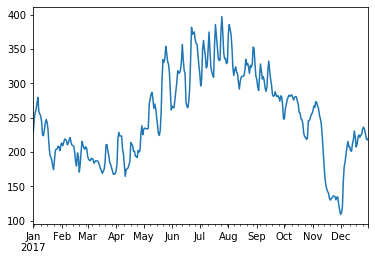

In [18]:
(density.south-density.north).plot();

In [ ]:
msouth = day_avg_south.rolling(window=4, center=True).mean()
mnorth = day_avg_north.rolling(window=4, center=True).mean()

In [46]:
sigmaS = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [saltS, tempS])

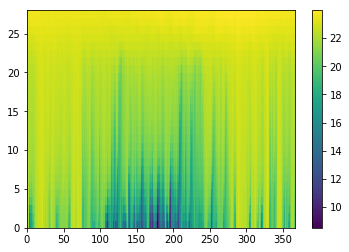

In [50]:
plt.pcolormesh(sigmaS.transpose())
plt.colorbar()

In [51]:
sigmaV = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [saltV, tempV])

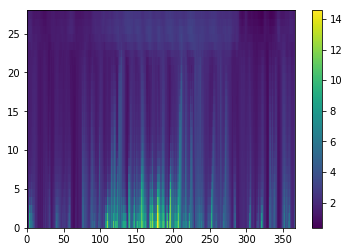

In [52]:
plt.pcolormesh((sigmaV-sigmaS).transpose())
plt.colorbar()

In [58]:
mesh.variables['gdepw_1d'][0, iZ]

134.34593444209906